# Libs

In [70]:
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense, Masking
import matplotlib
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from WickelfeaturesProject.keras_metrics import KerasMetrics
from keras.optimizers import adam
opt = adam()

# Data

corpus = pd.read_csv("WickelfeaturesProject/Corpus new coding/corpus_complete.csv", names=['verb0', 'inf_verb', 'conj_verb0', 'conj_verb'])

corpus.drop(['verb0','conj_verb0'], axis=1,inplace=True)

corpus['conj_verb'] = corpus.conj_verb.apply(lambda x: x.strip('#'))

corpus['inf_verb'] = corpus.inf_verb.apply(lambda x: x.strip('#'))

corpus.to_csv('WickelfeaturesProject/Corpus new coding/actual_corpus_used', index=False)

In [104]:
corpus = pd.read_csv('WickelfeaturesProject/Corpus new coding/actual_corpus_used' )

# Features

In [10]:
features = ['oclusiva', 'nasal', 'tepe', 'fricativa', 'l-aprox', 'bilabial', 'labiodental',
           'alveolar', 'p-alveolar', 'palatal', 'velar', 'glotal', 'vozeada', 'fechada',
           'm-fechada', 'm-aberta', 'aberta', 'anterior', 'posterior']

In [11]:
#http://www.ipachart.com/
phones = {
"p" : ['bilabial', 'oclusiva'],
"b" : ['bilabial', 'oclusiva', 'vozeada'],
"f" : ['labiodental', 'fricativa'],
"v" : ['labiodental', 'fricativa', 'vozeada'],
"t" : ['alveolar', 'oclusiva'],
"d" : ['alveolar', 'oclusiva', 'vozeada'],
"m" : ['bilabial', 'nasal'],
"n" : ['alveolar', 'nasal'],
"k" : ['velar', 'oclusiva'],
"g" : ['velar', 'oclusiva', 'vozeada'],
"N" : ['nasal', 'palatal'],
"r" : ['alveolar', 'tepe'],
"s" : ['alveolar', 'fricativa'],
"z" : ['alveolar', 'fricativa', 'vozeada'],
"j" : ['p-alveolar', 'fricativa', 'vozeada'],
"l" : ['l-aprox', 'p-alveolar'],
"L" : ['l-aprox', 'palatal'],
"h" : ['glotal', 'fricativa'],
"x" : ['fricativa', 'p-alveolar'],
"i" : ['anterior', 'fechada'],
"e" : ['m-fechada', 'anterior'],
"E" : ['m-aberta', 'anterior'],
"a" : ['anterior', 'aberta'],
"u" : ['posterior', 'fechada'],
"o" : ['m-fechada', 'posterior'],
"O" : ['m-aberta', 'posterior'],
"A" : ['anterior', 'aberta', 'nasal'],
"3" : ['m-fechada', 'anterior', 'nasal']}

# Functions

In [12]:
def code(phone): 
    array = []
    for item in features:
        if item in phones[phone]:
            array.append(1)
        else:
            array.append(0)
    return np.array(array)

In [13]:
code('h')

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [13]:
def code_verb(verb):
    coded = list()
    for item in verb:
        coded.append(code(item))
    return coded

In [14]:
code_verb('falu')

[array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]),
 array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1])]

In [15]:
def verify(verb):
    for phone in verb:
        if phone not in phones.keys():
            print(phone, verb)
        else:
            None

In [16]:
phones.keys()

dict_keys(['p', 'b', 'f', 'v', 't', 'd', 'm', 'n', 'k', 'g', 'N', 'r', 's', 'z', 'j', 'l', 'L', 'h', 'x', 'i', 'e', 'E', 'a', 'u', 'o', 'O', 'A', '3'])

In [17]:
corpus.inf_verb.apply(verify)

0      None
1      None
2      None
3      None
4      None
5      None
6      None
7      None
8      None
9      None
10     None
11     None
12     None
13     None
14     None
15     None
16     None
17     None
18     None
19     None
20     None
21     None
22     None
23     None
24     None
25     None
26     None
27     None
28     None
29     None
       ... 
393    None
394    None
395    None
396    None
397    None
398    None
399    None
400    None
401    None
402    None
403    None
404    None
405    None
406    None
407    None
408    None
409    None
410    None
411    None
412    None
413    None
414    None
415    None
416    None
417    None
418    None
419    None
420    None
421    None
422    None
Name: inf_verb, Length: 423, dtype: object

# Maximum Length of input and output

In [18]:
corpus.inf_verb.str.len().max()

11

In [19]:
corpus.conj_verb.str.len().max()

11

# Padding

In [20]:
coded_in = corpus.inf_verb.apply(code_verb)

In [21]:
coded_out = corpus.conj_verb.apply(code_verb)

In [ ]:
# define sequences
sequences = [
    [1, 2, 3, 4],
       [1, 2, 3],
             [1]
    ]
# pad sequence

In [36]:
padded_in = pad_sequences(coded_in, value=np.zeros(19))
padded_out = pad_sequences(coded_out, value=np.zeros(19),padding="post")

In [22]:
padded_out = pad_sequences(coded_out, value=np.zeros(19),padding="post")
padded_out.shape

(423, 11, 19)

about pre padding: https://stackoverflow.com/questions/46298793/how-does-choosing-between-pre-and-post-zero-padding-of-sequences-impact-results

# Test Split

In [85]:
x_test = padded_in[-30:]
y_test = padded_out[-30:]

padded_in = padded_in[:-30]
padded_out = padded_out[:-30]

# The Network

In [79]:
latent_dim = 256
num_encoder_tokens = 19

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens)) #19
#encoder_inputs = Masking()(encoder_inputs) # Assuming PAD is zeros
encoder = LSTM(latent_dim, return_state=True)
# Now the LSTM will ignore the PADs when encoding
# by skipping those timesteps that are masked
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
num_decoder_tokens = 19
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='sigmoid')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [38]:
num_encoder_tokens

19

In [39]:
padded_out[0]

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32)

In [43]:
coded_out_target = coded_out.apply(lambda x: np.vstack((x[1:],np.zeros(19))))

In [45]:
padded_out_target = pad_sequences(coded_out_target, value=np.zeros(19),padding="post")

In [46]:
padded_out_target.shape

(423, 11, 19)

In [ ]:
%%time
# Run training
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['f1'],)
history = model.fit([padded_in, padded_out],
                    padded_out_target,
                    batch_size=32,
                    epochs=300,
                    validation_split=0.2,verbose=True)

In [54]:
%matplotlib inline
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


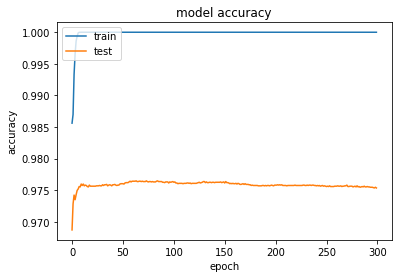

In [55]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(pd.Series(history.history['val_acc']))
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

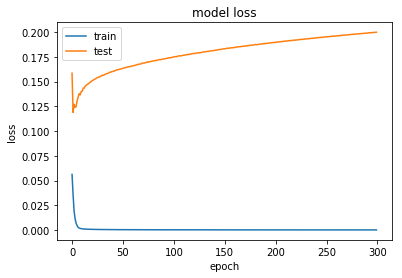

In [56]:
%matplotlib inline
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

different batch size

In [64]:
import keras.backend as K
from sklearn.metrics import f1_score

In [82]:
def mean_pred(y_true, y_pred):
    print(K.shape(y_true))
    return K.mean(y_pred[y_true == 1])

In [ ]:
def mean_pred(y_true, y_pred):
    
    return K.mean(y_pred[y_true == 1])

In [83]:
%%time
# Run training
keras_metrics = KerasMetrics()
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[ keras_metrics.fbeta_score,
               keras_metrics.recall,
               keras_metrics.precision,
                                                                 mean_pred],)
history2 = model.fit([padded_in, padded_out],
                    padded_out_target,
                    batch_size=128,
                    epochs=50,
                    validation_split=0.2,verbose=True)

Tensor("metrics_10/mean_pred/Shape:0", shape=(3,), dtype=int32)


TypeError: Value passed to parameter 'begin' has DataType bool not in list of allowed values: int32, int64

In [75]:
history2.history.keys()

dict_keys(['val_loss', 'val_fbeta_score', 'val_recall', 'val_precision', 'loss', 'fbeta_score', 'recall', 'precision'])

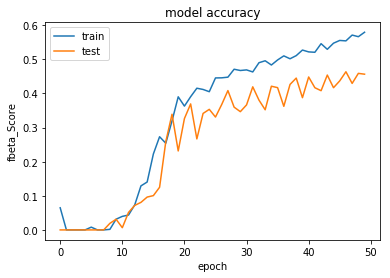

In [81]:
# summarize history for accuracy
plt.plot(history2.history['fbeta_score'])
plt.plot(pd.Series(history2.history['val_fbeta_score']))
plt.title('model accuracy')
plt.ylabel('fbeta_Score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

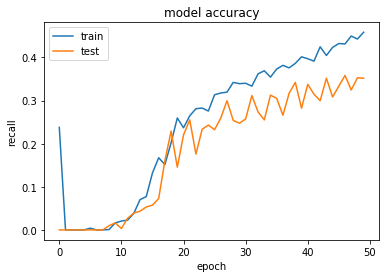

In [84]:
# summarize history for accuracy
score = 'recall'
plt.plot(history2.history[score])
plt.plot(pd.Series(history2.history['val_{}'.format(score)]))
plt.title('model accuracy')
plt.ylabel(score)
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

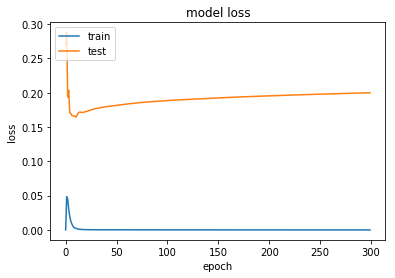

In [61]:
%matplotlib inline
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

# Predict

## Euclidean Distance

In [7]:
from scipy.spatial import distance
a = np.array([0,0,1])
b = np.array([0, 0, 1])
dst = distance.euclidean(a, b)
dst

0.0

In [14]:
phone_arrays = {}
for phone in phones:
    phone_arrays[phone] = code(phone)
phone_arrays

{'p': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'b': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 'f': array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'v': array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 't': array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'd': array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 'm': array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'n': array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'k': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'g': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]),
 'N': array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'r': array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 's': array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'z': array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 

In [17]:
def find_closest_array(predicted):
    """
    Find closest array.
    
    Parameters:
    ----------
    
    predicted : type array
    
    Returns:
    -------
    candidate : type string
    
    TODO: 
    -----
    return all possible candidates
    """
    min_dst = 10000
    more_than_one = []
    for phone in phone_arrays:
        dst = distance.euclidean(predicted, phone_arrays[phone])
        if dst < min_dst:
            min_dst = dst
            candidate = phone
#         elif dst == min_dst:
#             more_than_one.append(candidate)
#             more_than_one.append(phone)
    return candidate

In [18]:
find_closest_array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0])

'3'

 ---

In [ ]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [116]:
del phones

{'p': ['bilabial', 'oclusiva'],
 'b': ['bilabial', 'oclusiva', 'vozeada'],
 'f': ['labiodental', 'fricativa'],
 'v': ['labiodental', 'fricativa', 'vozeada'],
 't': ['alveolar', 'oclusiva'],
 'd': ['alveolar', 'oclusiva', 'vozeada'],
 'm': ['bilabial', 'nasal'],
 'n': ['alveolar', 'nasal'],
 'k': ['velar', 'oclusiva'],
 'g': ['velar', 'oclusiva', 'vozeada'],
 'N': ['nasal', 'palatal'],
 'r': ['alveolar', 'tepe'],
 's': ['alveolar', 'fricativa'],
 'z': ['alveolar', 'fricativa', 'vozeada'],
 'j': ['p-alveolar', 'fricativa', 'vozeada'],
 'l': ['l-aprox', 'p-alveolar'],
 'L': ['l-aprox', 'palatal'],
 'h': ['glotal', 'fricativa'],
 'x': ['fricativa', 'p-alveolar'],
 'i': ['anterior', 'fechada'],
 'e': ['m-fechada', 'anterior'],
 'E': ['m-aberta', 'anterior'],
 'a': ['anterior', 'aberta'],
 'u': ['posterior', 'fechada'],
 'o': ['m-fechada', 'posterior'],
 'O': ['m-aberta', 'posterior'],
 'A': ['anterior', 'aberta', 'nasal'],
 '3': ['m-fechada', 'anterior', 'nasal'],
 'PAD': array([0., 0., 0.,

In [114]:
lookup = dict()
phones['PAD'] = np.zeros(19)
for phone in phones:
    lookup[phone] = code(phone)
    

/disk1/home/svo6059/anaconda3/envs/bia/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


In [112]:
def reverse_phone(array):
    for item in lookup:
        if np.all(array == lookup[item]):
            return item

In [110]:
coded_in[0][0]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0])

In [111]:
reverse_phone(coded_in[0][0])

'A'

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 11, 19))
    # Populate the first character of target sequence with the start character.
    # target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_word = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence